# ANALISIS EXPLORATORIO

### ANALISIS DESCRIPTIVO

✅ Dimensiones del dataset: (1000, 23)

✅ Tipos de datos:
Unnamed: 0             int64
artist_name           object
genres                object
followers              int64
artist_popularity      int64
artist_url            object
track_name            object
album_name            object
release_date          object
duration_ms            int64
explicit                bool
track_popularity       int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
dtype: object

✅ Valores nulos por columna:
Unnamed: 0             0
artist_name            0
genres               163
followers              0
artist_popularity      0
artist_url             0
track_name             0
album_name             0
release_date           0
duratio

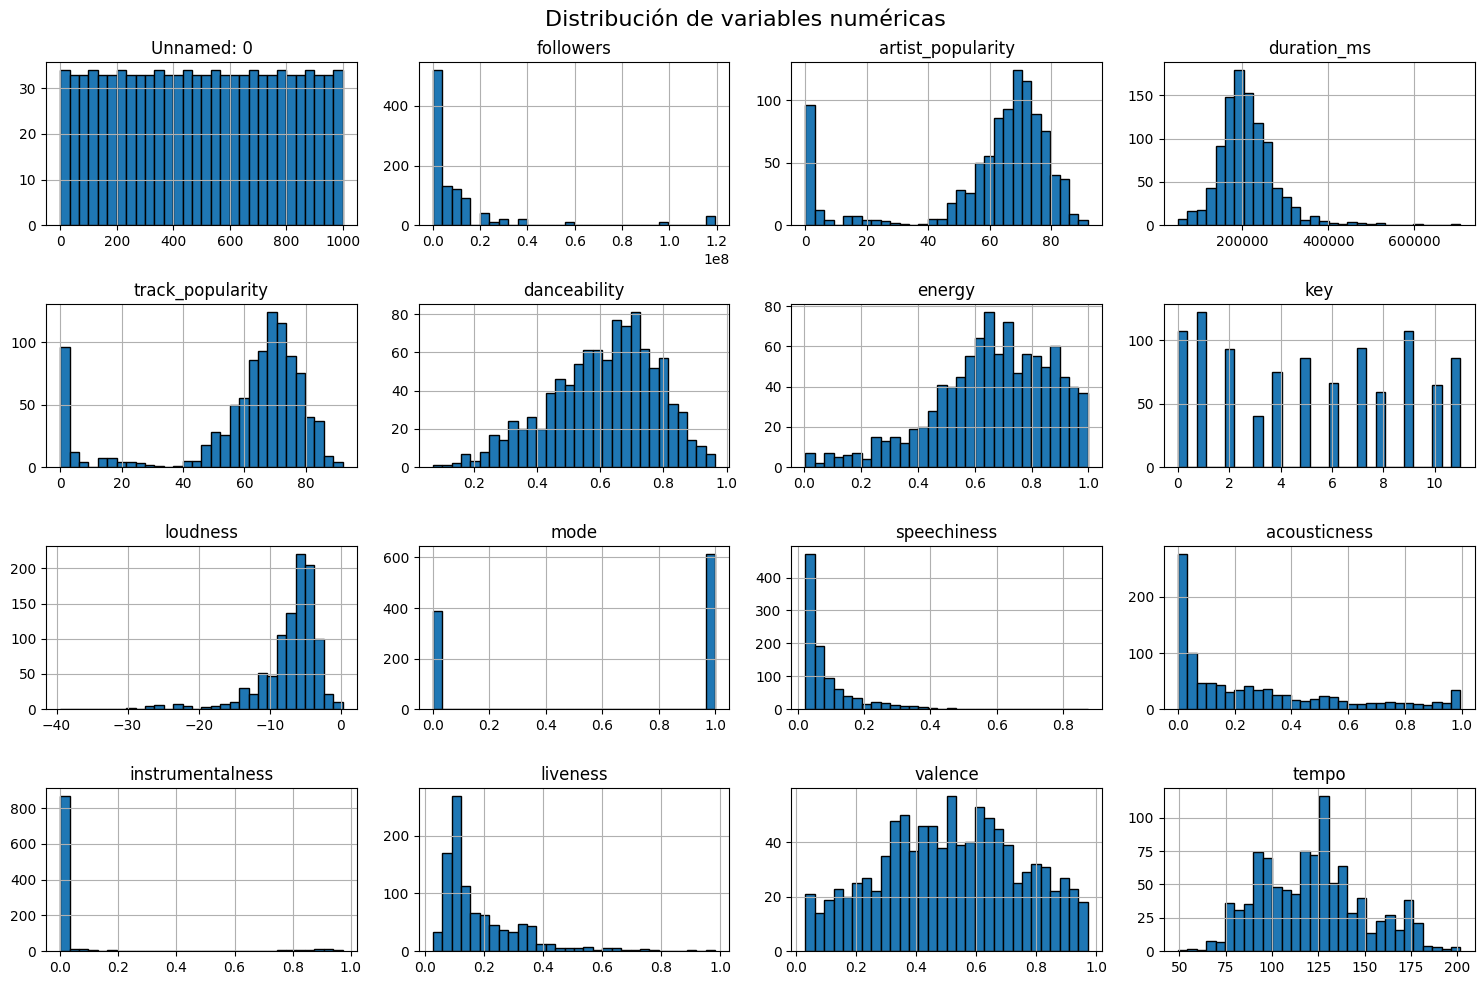


📈 Matriz de correlación:


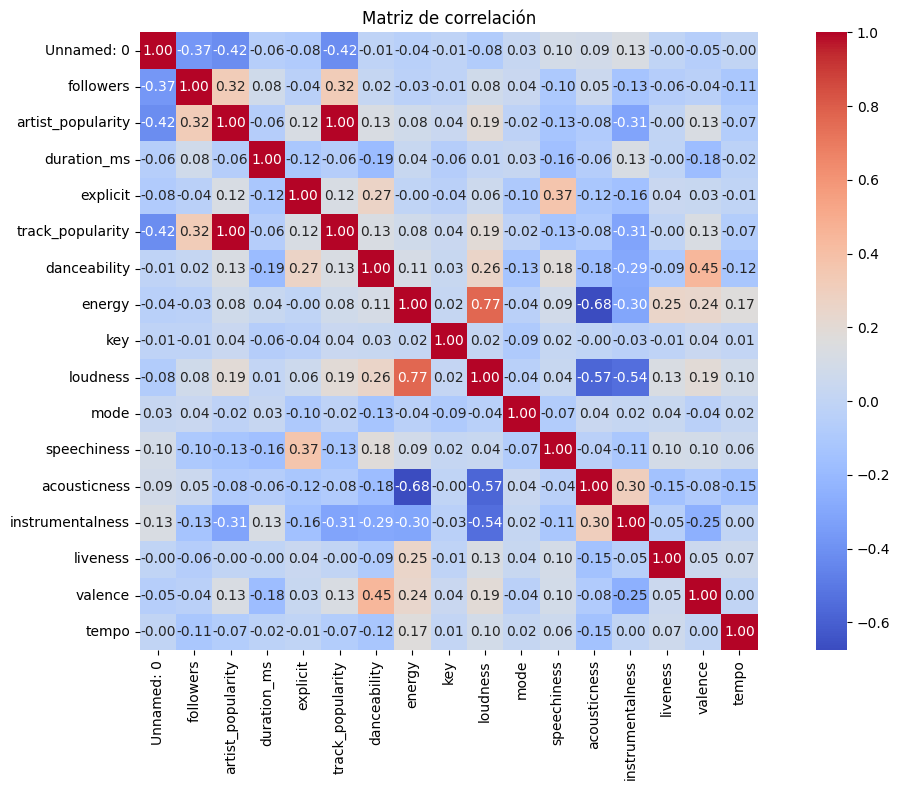


📦 Mostrando boxplots...


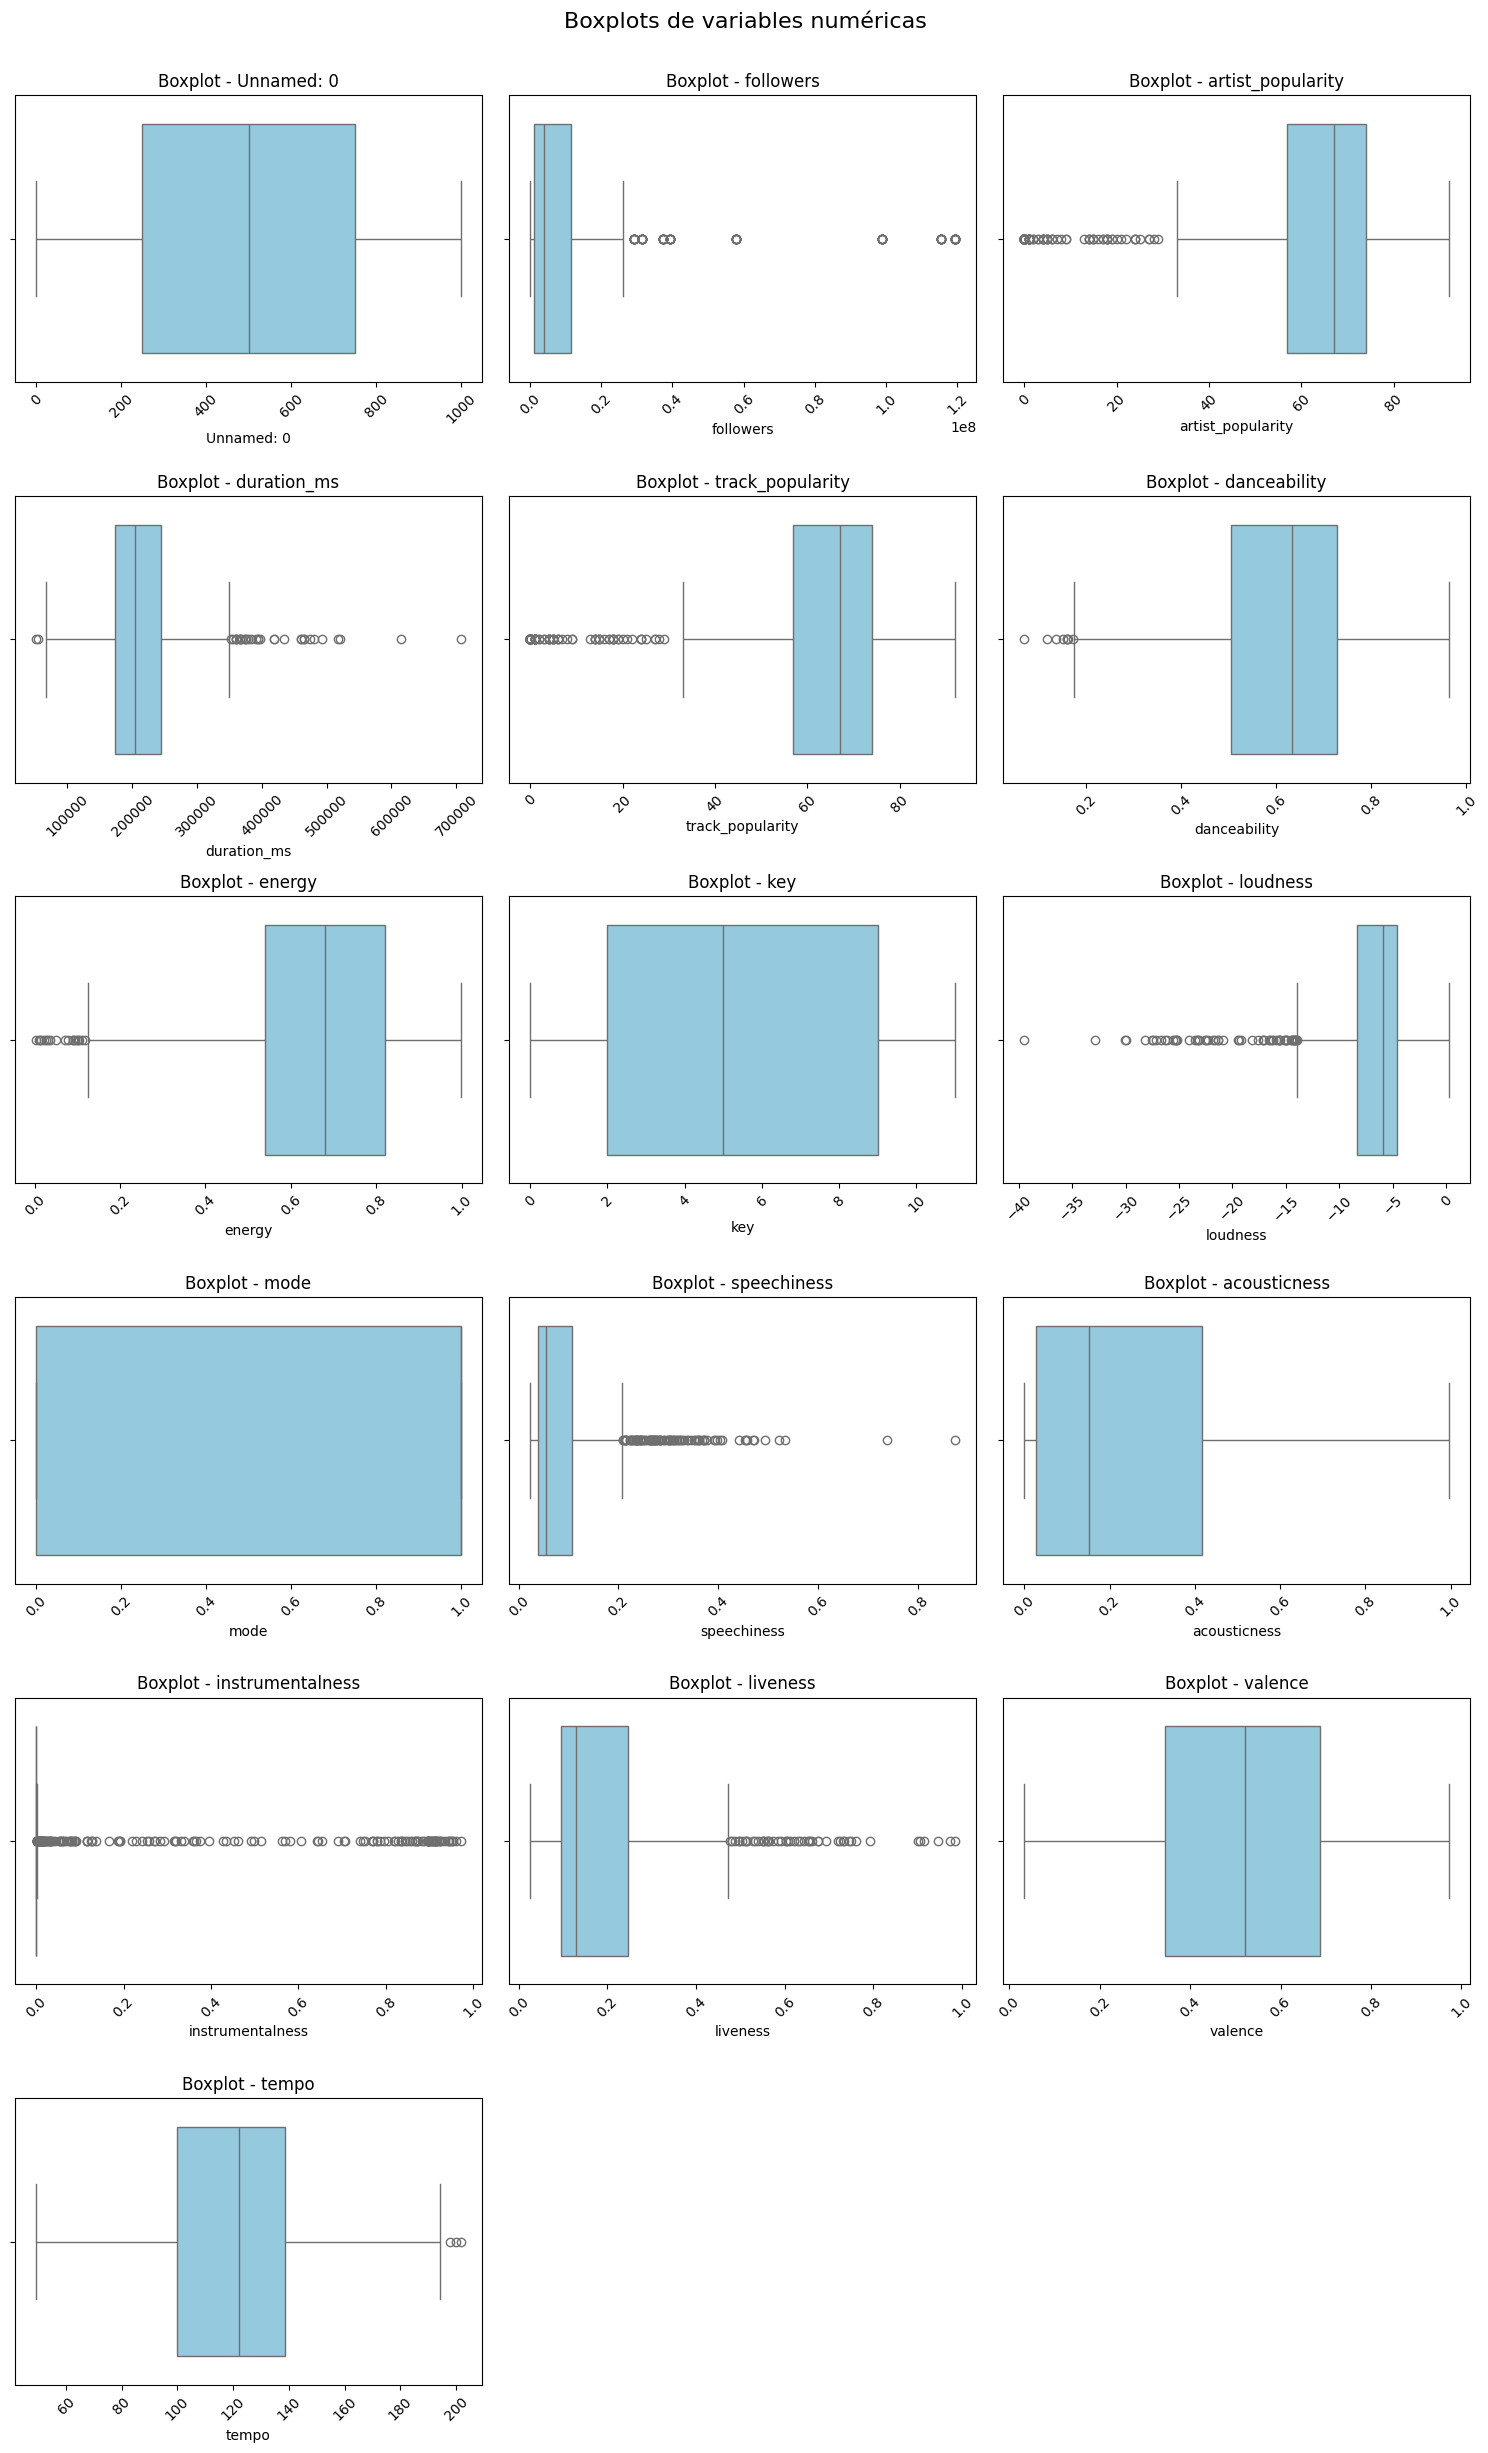

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. Cargar el dataset
# ===============================
df = pd.read_csv("SMUSIC.csv")

# ===============================
# 2. Información general
# ===============================
print("✅ Dimensiones del dataset:", df.shape)
print("\n✅ Tipos de datos:")
print(df.dtypes)

# ===============================
# 3. Valores nulos
# ===============================
print("\n✅ Valores nulos por columna:")
print(df.isnull().sum())

# ===============================
# 4. Estadísticas descriptivas
# ===============================
print("\n✅ Estadísticas de variables numéricas:")
print(df.describe())

print("\n✅ Estadísticas de variables categóricas:")
print(df.describe(include='object'))

# ===============================
# 5. Distribución de variables numéricas
# ===============================
print("\n📊 Mostrando histogramas...")
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()


# ===============================
# 7. Matriz de correlación
# ===============================
print("\n📈 Matriz de correlación:")
plt.figure(figsize=(12, 8))
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

# ===============================
# 8. Boxplots combinados
# ===============================
print("\n📦 Mostrando boxplots...")
num_cols = df.select_dtypes(include=np.number).columns
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot - {col}")
    axes[i].tick_params(axis='x', rotation=45)

# Quitar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Boxplots de variables numéricas", fontsize=16, y=1.02)
plt.show()


### ANALISIS DIAGNOSTICO


Valores nulos por columna:
genres               163
followers              0
artist_popularity      0
release_date           0
duration_ms            0
explicit               0
track_popularity       0
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
popular                0
dtype: int64

Cardinalidad de 'genres': 81
Top 10 géneros más frecuentes:
genres
unknown                                                                   163
pop                                                                        40
dance pop, pop                                                             20
british soul, pop, pop soul, uk pop                                        10
east coast hip hop, hip hop, rap                                           10
reggaeton, reggaeton flow,

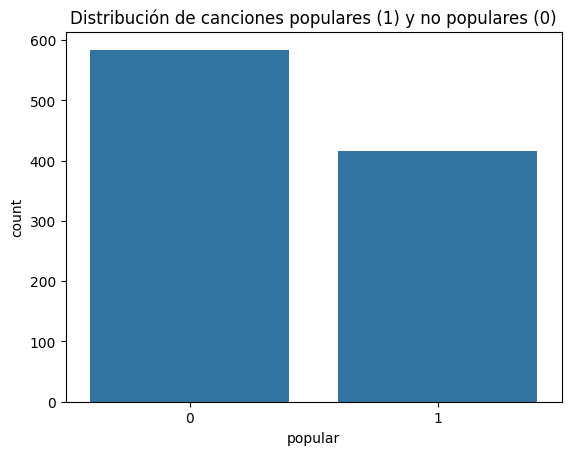

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar dataset
df = pd.read_csv("SMUSIC.csv")

# --- 1. Crear variable objetivo 'popular' ---
df['popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

# --- 2. Columnas irrelevantes para modelado ---
cols_to_drop = ['Unnamed: 0', 'artist_name', 'track_name', 'album_name', 'artist_url']
df_model = df.drop(columns=cols_to_drop)

# --- 3. Valores nulos ---
print("\nValores nulos por columna:")
print(df_model.isnull().sum())

# Tratar nulos en 'genres'
df_model['genres'] = df_model['genres'].fillna('unknown')

# --- 4. Cardinalidad en 'genres' ---
print("\nCardinalidad de 'genres':", df_model['genres'].nunique())
print("Top 10 géneros más frecuentes:")
print(df_model['genres'].value_counts().head(10))

# Reducir cardinalidad
top_genres = df_model['genres'].value_counts().nlargest(10).index
df_model['genres'] = df_model['genres'].apply(lambda x: x if x in top_genres else 'other')

# --- 5. Codificación ---
df_model['explicit'] = df_model['explicit'].astype(int)
df_model = pd.get_dummies(df_model, columns=['genres', 'mode'], drop_first=True)

# --- 6. Detección de colinealidad ---
corr = df_model.corr(numeric_only=True)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

print("\nPares de variables con correlación > 0.9:")
high_corr = []
for col in upper.columns:
    for row in upper.index:
        val = upper.loc[row, col]
        if pd.notnull(val) and abs(val) > 0.9:
            high_corr.append((row, col, val))
            print(f"{row} vs {col}: {val:.2f}")

# --- 7. Detección de outliers (IQR) ---
def detectar_outliers(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    return ((col < (q1 - 1.5*iqr)) | (col > (q3 + 1.5*iqr))).sum()

print("\nNúmero de outliers por variable numérica:")
for col in df_model.select_dtypes(include='number').columns:
    if col not in ['track_popularity', 'popular']:
        n_outliers = detectar_outliers(df_model[col])
        print(f"{col}: {n_outliers}")

# --- 8. Balance de clases ---
print("\nDistribución de clases en 'popular':")
print(df_model['popular'].value_counts(normalize=True))

sns.countplot(x='popular', data=df_model)
plt.title("Distribución de canciones populares (1) y no populares (0)")
plt.show()


In [7]:
# 1. Rellenar nulos en genres
df['genres'] = df['genres'].fillna('unknown')

# 2. Reducir cardinalidad de genres
top_genres = df['genres'].value_counts().nlargest(10).index
df['genres'] = df['genres'].apply(lambda x: x if x in top_genres else 'other')

# 3. Eliminar variable multicolineal (artist_popularity)
df = df.drop(columns=['artist_popularity'])

# 4. Aplicar transformación logarítmica a followers y duration_ms para controlar outliers
import numpy as np
df['followers_log'] = np.log1p(df['followers'])
df['duration_ms_log'] = np.log1p(df['duration_ms'])


## ANALISIS UNIVARIANTE, BIVARIANTE , MULTIVARIANTE &  DE CORELACIONES

In [9]:
!pip install plotly


   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------- ----------------------------- 2.6/9.6 MB 25.4 MB/s eta 0:00:01
   ------------------------------------- -- 8.9/9.6 MB 27.7 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 26.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install nbformat --upgrade


  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.24.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.24.0-py3-none-any.whl (88 kB)
Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl (18 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("SMUSIC.csv")

# Variable a analizar, por ejemplo 'followers'
fig_hist = px.histogram(df, x='followers', nbins=50, title='Histograma de Followers', marginal="box")
fig_hist.show()


In [2]:
# Crear variable popular
df['popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

fig_box = px.box(df, x='popular', y='danceability', points="all",
                 title="Danceability por Popularidad (0=No, 1=Sí)",
                 labels={'popular': 'Popular', 'danceability': 'Danceability'})
fig_box.show()


In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

features = ['danceability', 'energy', 'valence', 'speechiness', 'followers', 'duration_ms']
df_pca = df.dropna(subset=features + ['popular'])

X = df_pca[features]
y = df_pca['popular']

# Escalar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]

fig_pca = px.scatter(df_pca, x='PC1', y='PC2', color='popular',
                     title="PCA 2D de características seleccionadas",
                     labels={'PC1': 'Componente Principal 1', 'PC2': 'Componente Principal 2', 'popular': 'Popular'},
                     hover_data=features)
fig_pca.show()


In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

df = pd.read_csv("SMUSIC.csv")
df['popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

features = ['danceability', 'energy', 'valence', 'speechiness', 'followers', 'duration_ms']
df_pca = df.dropna(subset=features + ['popular'])

X = df_pca[features]
y = df_pca['popular']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]
df_pca['PC3'] = X_pca[:, 2]

fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='popular',
                    title='PCA 3D de características seleccionadas',
                    labels={'PC1': 'Componente Principal 1', 'PC2': 'Componente Principal 2', 'PC3': 'Componente Principal 3'},
                    hover_data=features)
fig.show()


In [5]:
import numpy as np
import plotly.figure_factory as ff

corr = df[features + ['popular']].corr()

# Crear mapa de calor con anotaciones
fig_corr = ff.create_annotated_heatmap(
    z=np.round(corr.values, 2),
    x=list(corr.columns),
    y=list(corr.index),
    colorscale='Viridis',
    showscale=True,
    hoverinfo='z'
)

fig_corr.update_layout(title='Mapa de calor interactivo de correlaciones')
fig_corr.show()


In [7]:
!pip install dash plotly pandas scikit-learn


  Using cached flask-3.1.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached importlib_metadata-8.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.9 MB ? eta -:--:--
   --- ------------------------------------ 0.8/7.9 MB 2.8 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/7.9 MB 2.9 MB/s eta 0:00:03
   --------------- ------------------------ 3.1/7.9 MB 4.1 MB/s eta 0:00:02
   ------------------------- -------------- 5.0/7.9 MB 5.2 MB/s eta 0:00:01
   ----------------------------


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd
import numpy as np
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Cargar y preparar datos
df = pd.read_csv("SMUSIC.csv")
df['popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

features = ['danceability', 'energy', 'valence', 'speechiness', 'followers', 'duration_ms']
df_clean = df.dropna(subset=features + ['popular'])

X_scaled = StandardScaler().fit_transform(df_clean[features])
pca = PCA(n_components=3).fit_transform(X_scaled)

df_clean['PC1'] = pca[:, 0]
df_clean['PC2'] = pca[:, 1]
df_clean['PC3'] = pca[:, 2]

# Iniciar app
app = Dash(__name__)
app.title = "EDA Dashboard Música 🎵"

app.layout = html.Div([
    html.H1("Análisis Exploratorio Interactivo de Canciones 🎧", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Selecciona una variable numérica:"),
        dcc.Dropdown(features, value='danceability', id='var-dropdown')
    ], style={'width': '40%', 'margin': 'auto'}),

    html.Div([
        dcc.Graph(id='hist-boxplot'),
        dcc.Graph(id='box-vs-popular')
    ]),

    html.Div([
        html.H3("PCA 3D de características"),
        dcc.Graph(
            id='pca-3d',
            figure=px.scatter_3d(df_clean, x='PC1', y='PC2', z='PC3', color='popular',
                                 title='PCA 3D',
                                 labels={'popular': 'Popular'},
                                 hover_data=features)
        )
    ]),

    html.Div([
        html.H3("Mapa de calor de correlaciones"),
        dcc.Graph(
            id='heatmap-corr',
            figure=ff.create_annotated_heatmap(
                z=np.round(df_clean[features + ['popular']].corr().values, 2),
                x=list(df_clean[features + ['popular']].columns),
                y=list(df_clean[features + ['popular']].columns),
                colorscale='Viridis',
                showscale=True,
                hoverinfo='z'
            )
        )
    ])
])

@app.callback(
    Output('hist-boxplot', 'figure'),
    Output('box-vs-popular', 'figure'),
    Input('var-dropdown', 'value')
)
def update_graphs(selected_var):
    fig_hist = px.histogram(df_clean, x=selected_var, nbins=40,
                            marginal='box', title=f'Distribución y boxplot de {selected_var}')
    
    fig_box = px.box(df_clean, x='popular', y=selected_var, points='all',
                     title=f'{selected_var} según popularidad', labels={'popular': 'Popular'})
    return fig_hist, fig_box

if __name__ == '__main__':
    app.run(debug=True)



# ANALISIS DE DATOS

# PREPROCESAMIENTO

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocesar_df(df):
    # 1. Crear variable objetivo binaria
    df = df.copy()
    df['popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

    # 2. Imputar valores nulos en 'genres'
    df['genres'] = df['genres'].fillna('unknown')

    # 3. Reducir cardinalidad: quedarnos con los 10 más comunes
    top_genres = df['genres'].value_counts().nlargest(10).index
    df['genres'] = df['genres'].apply(lambda x: x if x in top_genres else 'other')

    # 4. Convertir variable booleana a numérica
    df['explicit'] = df['explicit'].astype(int)

    # 5. Eliminar columnas irrelevantes para modelado
    cols_to_drop = ['Unnamed: 0', 'artist_name', 'track_name', 'album_name', 'artist_url', 'release_date', 'artist_popularity']
    df = df.drop(columns=cols_to_drop, errors='ignore')  # ignora si alguna ya no está

    # 6. Transformar variables con outliers usando log1p
    df['followers'] = np.log1p(df['followers'])
    df['duration_ms'] = np.log1p(df['duration_ms'])

    # 7. One-hot encoding para categóricas
    df = pd.get_dummies(df, columns=['genres', 'mode'], drop_first=True)

    # 8. Separar features (X) y etiquetas (y)
    X = df.drop(columns=['track_popularity', 'popular'])
    y = df['popular']

    # 9. Escalar variables numéricas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, X.columns


In [11]:
import pandas as pd

# Cargar datos
df = pd.read_csv("SMUSIC.csv")

# Preprocesar
X, y, scaler, feature_names = preprocesar_df(df)

In [13]:
import pandas as pd
import numpy as np
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === Cargar datos ===
df = pd.read_csv("SMUSIC.csv")

# === Preprocesamiento "ANTES" ===
df_raw = df.copy()
df_raw['popular'] = df_raw['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)
df_raw['genres'] = df_raw['genres'].fillna('unknown')
top_genres = df_raw['genres'].value_counts().nlargest(10).index
df_raw['genres'] = df_raw['genres'].apply(lambda x: x if x in top_genres else 'other')
df_raw['explicit'] = df_raw['explicit'].astype(int)

# Variables antes del procesamiento
features_raw = ['followers', 'duration_ms', 'danceability', 'energy', 'valence', 'speechiness']

# === Preprocesamiento "DESPUÉS" ===
df_proc = df_raw.copy()
df_proc['followers'] = np.log1p(df_proc['followers'])
df_proc['duration_ms'] = np.log1p(df_proc['duration_ms'])
df_proc = pd.get_dummies(df_proc, columns=['genres', 'mode'], drop_first=True)
df_proc = df_proc.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'album_name',
                                'artist_url', 'release_date', 'track_popularity', 'artist_popularity'], errors='ignore')

X_proc = df_proc.drop(columns=['popular'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_proc)

df_scaled = pd.DataFrame(X_scaled, columns=X_proc.columns)
df_scaled['popular'] = df_proc['popular'].values

# PCA 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
df_scaled['PC1'], df_scaled['PC2'], df_scaled['PC3'] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]

# === Iniciar dashboard ===
app = Dash(__name__)
app.title = "EDA Antes y Después del Preprocesamiento"

app.layout = html.Div([
    html.H1("🎵 Comparación Antes vs Después del Preprocesamiento", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Selecciona una variable numérica original:"),
        dcc.Dropdown(features_raw, value='followers', id='var-selector'),
    ], style={'width': '40%', 'margin': 'auto'}),

    html.Div([
        html.H3("📊 Histogramas antes y después"),
        dcc.Graph(id='histogram-before'),
        dcc.Graph(id='histogram-after')
    ]),

    html.Div([
        html.H3("📦 Boxplots antes y después"),
        dcc.Graph(id='boxplot-before'),
        dcc.Graph(id='boxplot-after')
    ]),

    html.Div([
        html.H3("🧠 PCA 3D de variables escaladas"),
        dcc.Graph(
            id='pca-3d',
            figure=px.scatter_3d(df_scaled, x='PC1', y='PC2', z='PC3', color='popular',
                                 title='PCA 3D (Datos Preprocesados)',
                                 hover_data=df_scaled.columns,
                                 labels={'popular': 'Popular'})
        )
    ]),

    html.Div([
        html.H3("🔥 Mapa de calor de correlaciones (antes vs después)"),
        dcc.Tabs([
            dcc.Tab(label="Antes del procesamiento", children=[
                dcc.Graph(
                    figure=ff.create_annotated_heatmap(
                        z=np.round(df_raw[features_raw + ['popular']].corr().values, 2),
                        x=features_raw + ['popular'],
                        y=features_raw + ['popular'],
                        colorscale='Viridis',
                        showscale=True,
                        hoverinfo='z'
                    )
                )
            ]),
            dcc.Tab(label="Después del procesamiento", children=[
                    dcc.Graph(
                    figure=ff.create_annotated_heatmap(
                        z=np.round(df_scaled.corr().values, 2),
                        x=list(df_scaled.columns),
                        y=list(df_scaled.columns),
                        colorscale='Viridis',
                        showscale=True,
                        hoverinfo='z'
                    )
                )

            ])
        ])
    ])
])


@app.callback(
    Output('histogram-before', 'figure'),
    Output('histogram-after', 'figure'),
    Output('boxplot-before', 'figure'),
    Output('boxplot-after', 'figure'),
    Input('var-selector', 'value')
)
def update_graphs(var):
    # Histogramas
    hist_before = px.histogram(df_raw, x=var, nbins=40, color='popular',
                                title=f'{var} antes del preprocesamiento', barmode='overlay')
    
    hist_after = px.histogram(df_scaled, x=var, nbins=40, color='popular',
                               title=f'{var} después del preprocesamiento (escalado)', barmode='overlay')

    # Boxplots
    box_before = px.box(df_raw, y=var, color='popular',
                         title=f'{var} antes del preprocesamiento')
    
    box_after = px.box(df_scaled, y=var, color='popular',
                        title=f'{var} después del preprocesamiento (z-score)')
    
    return hist_before, hist_after, box_before, box_after

if __name__ == '__main__':
    app.run(debug=True)


### ANALISIS PREDICTIVO

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# === 1. Cargar y preprocesar datos ===
df = pd.read_csv("SMUSIC.csv")

def preprocesar_df(df):
    df = df.copy()
    df['popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)
    df['genres'] = df['genres'].fillna('unknown')
    top_genres = df['genres'].value_counts().nlargest(10).index
    df['genres'] = df['genres'].apply(lambda x: x if x in top_genres else 'other')
    df['explicit'] = df['explicit'].astype(int)
    cols_to_drop = ['Unnamed: 0', 'artist_name', 'track_name', 'album_name',
                    'artist_url', 'release_date', 'track_popularity', 'artist_popularity']
    df = df.drop(columns=cols_to_drop, errors='ignore')
    df['followers'] = np.log1p(df['followers'])
    df['duration_ms'] = np.log1p(df['duration_ms'])
    df = pd.get_dummies(df, columns=['genres', 'mode'], drop_first=True)
    X = df.drop(columns=['popular'])
    y = df['popular']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

X, y, scaler = preprocesar_df(df)

# === 2. Dividir en entrenamiento y prueba ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. Definir modelos base ===
clf_lr = LogisticRegression(max_iter=1000)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# === 4. Crear Voting Classifier (voting='soft' para usar probabilidades) ===
voting_clf = VotingClassifier(
    estimators=[('lr', clf_lr), ('rf', clf_rf), ('gb', clf_gb)],
    voting='soft'
)

# === 5. Entrenar modelo ===
voting_clf.fit(X_train, y_train)

# === 6. Evaluación ===
y_pred = voting_clf.predict(X_test)

print("=== Matriz de Confusión ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred))

print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.2%}")


=== Matriz de Confusión ===
[[103  14]
 [ 34  49]]

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       117
           1       0.78      0.59      0.67        83

    accuracy                           0.76       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.76      0.76      0.75       200


✅ Accuracy: 76.00%


=== Clasificación ===
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       117
           1       0.78      0.59      0.67        83

    accuracy                           0.76       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.76      0.76      0.75       200


=== Accuracy: 76.00%


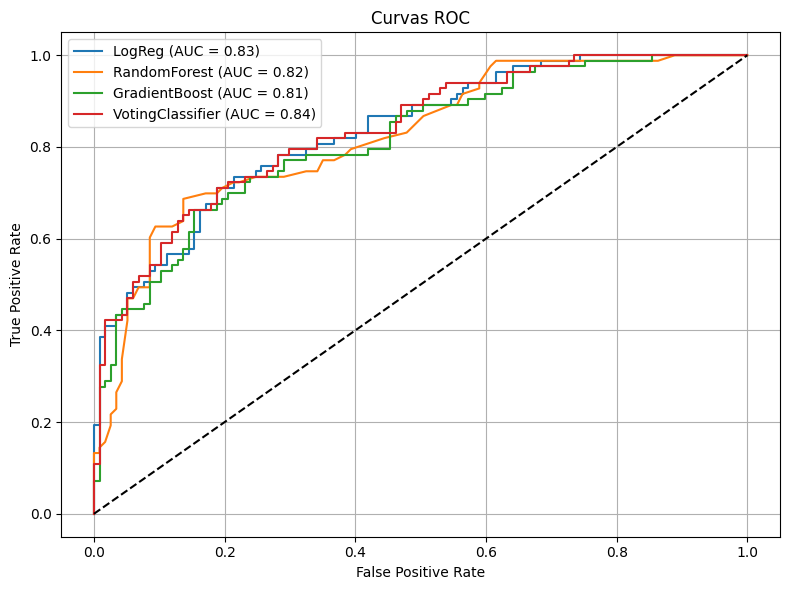


=== Validación cruzada (5 folds) ===
Scores individuales: [0.7   0.67  0.68  0.705 0.715]
Media: 69.40%, Std: 1.66%


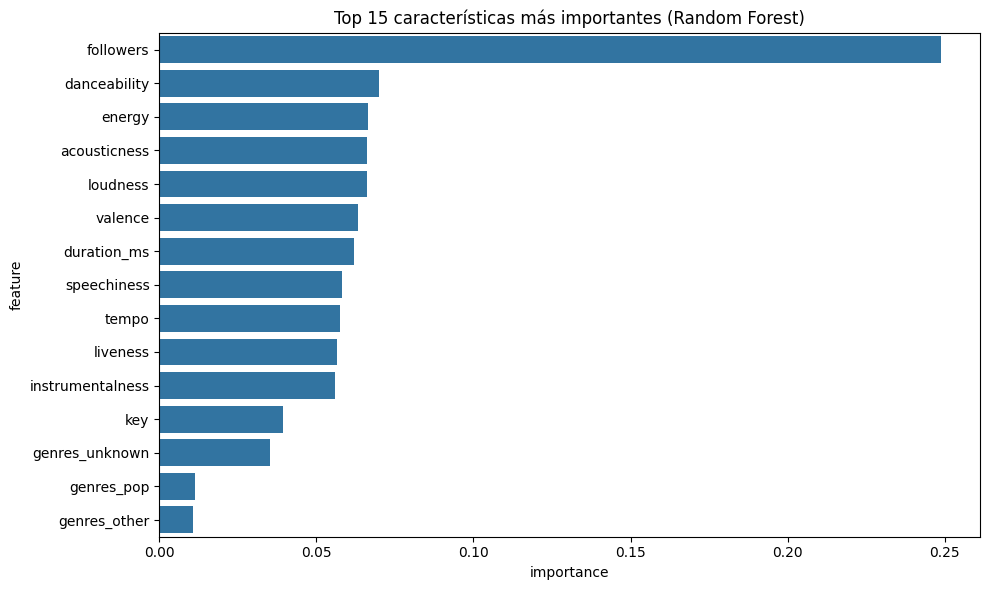


✅ Modelo, scaler y columnas guardados como archivos .pkl


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# === Preprocesamiento ===
def preprocesar_df(df):
    df = df.copy()
    df['popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)
    df['genres'] = df['genres'].fillna('unknown')
    top_genres = df['genres'].value_counts().nlargest(10).index
    df['genres'] = df['genres'].apply(lambda x: x if x in top_genres else 'other')
    df['explicit'] = df['explicit'].astype(int)
    df.drop(columns=[
        'Unnamed: 0', 'artist_name', 'track_name', 'album_name',
        'artist_url', 'release_date', 'track_popularity', 'artist_popularity'
    ], inplace=True, errors='ignore')
    df['followers'] = np.log1p(df['followers'])
    df['duration_ms'] = np.log1p(df['duration_ms'])
    df = pd.get_dummies(df, columns=['genres', 'mode'], drop_first=True)
    X = df.drop(columns=['popular'])
    y = df['popular']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler, X.columns

# === Cargar y preparar ===
df = pd.read_csv("SMUSIC.csv")
X, y, scaler, feature_names = preprocesar_df(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Modelos base ===
clf_lr = LogisticRegression(max_iter=1000)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# === VotingClassifier ===
voting_clf = VotingClassifier(
    estimators=[('lr', clf_lr), ('rf', clf_rf), ('gb', clf_gb)],
    voting='soft'
)

# === Entrenar ===
voting_clf.fit(X_train, y_train)

# === Evaluación ===
y_pred = voting_clf.predict(X_test)
print("=== Clasificación ===")
print(classification_report(y_test, y_pred))
print("\n=== Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

# === Curvas ROC ===
def plot_roc(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Curvas ROC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_roc({
    "LogReg": clf_lr.fit(X_train, y_train),
    "RandomForest": clf_rf.fit(X_train, y_train),
    "GradientBoost": clf_gb.fit(X_train, y_train),
    "VotingClassifier": voting_clf
}, X_test, y_test)

# === Cross-validation ===
scores = cross_val_score(voting_clf, X, y, cv=5, scoring='accuracy')
print("\n=== Validación cruzada (5 folds) ===")
print("Scores individuales:", scores)
print("Media: {:.2f}%, Std: {:.2f}%".format(scores.mean() * 100, scores.std() * 100))

# === Importancia de características (desde Random Forest) ===
importances = clf_rf.feature_importances_
imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=imp_df.head(15))
plt.title("Top 15 características más importantes (Random Forest)")
plt.tight_layout()
plt.show()

# === Guardar modelo y scaler ===
joblib.dump(voting_clf, "modelo_voting.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_names.tolist(), "feature_names.pkl")

print("\n✅ Modelo, scaler y columnas guardados como archivos .pkl")


### ANALISIS PRESCRIPTIVO

In [16]:
import numpy as np
import pandas as pd

def simulate_multiple_features_effect(model, scaler, base_sample_dict, feature_ranges):
    """
    Simula cómo varía la probabilidad de popularidad al modificar varias features,
    una por una (análisis de sensibilidad univariante), manteniendo las demás constantes.

    Params:
        model: modelo entrenado con método predict_proba()
        scaler: objeto StandardScaler para escalar inputs
        base_sample_dict: dict con valores base de las features (antes de escalar)
        feature_ranges: dict {feature_name: array_de_valores_a_simular}

    Returns:
        dict {feature_name: DataFrame con columnas [feature_value, popular_prob]}
    """
    results = {}
    base_features = base_sample_dict.copy()

    for feat, values in feature_ranges.items():
        sim_results = []
        for val in values:
            sample = base_features.copy()
            sample[feat] = val
            # Convertir dict a DataFrame para escalar
            sample_df = pd.DataFrame([sample])
            sample_scaled = scaler.transform(sample_df)
            prob = model.predict_proba(sample_scaled)[0][1]  # prob popular=1
            sim_results.append([val, prob])
        results[feat] = pd.DataFrame(sim_results, columns=[feat, 'Popular_Prob'])
    return results


In [17]:
from scipy.optimize import minimize

def optimize_popularity(model, scaler, base_sample_dict, features_to_optimize, bounds):
    """
    Optimiza features para maximizar la probabilidad de popularidad.

    Params:
        model: modelo entrenado
        scaler: scaler usado
        base_sample_dict: valores base de todas las features
        features_to_optimize: lista de features a optimizar
        bounds: lista de tuplas (min, max) para cada feature a optimizar

    Returns:
        dict con valores óptimos y probabilidad máxima
    """
    def objective(x):
        sample = base_sample_dict.copy()
        for i, feat in enumerate(features_to_optimize):
            sample[feat] = x[i]
        sample_df = pd.DataFrame([sample])
        sample_scaled = scaler.transform(sample_df)
        # Queremos maximizar probabilidad, pero minimize minimiza, así que invertimos signo
        prob = model.predict_proba(sample_scaled)[0][1]
        return -prob

    x0 = [base_sample_dict[feat] for feat in features_to_optimize]
    res = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')
    optimized_vals = {feat: res.x[i] for i, feat in enumerate(features_to_optimize)}
    max_prob = -res.fun
    return optimized_vals, max_prob


In [20]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import numpy as np
import joblib

# === Cargar modelo, scaler y nombres de features guardados ===
voting_clf = joblib.load("modelo_voting.pkl")
scaler = joblib.load("scaler.pkl")
feature_names = joblib.load("feature_names.pkl")

# Variables para el dashboard (puedes ajustar)
features = ['danceability', 'energy', 'valence', 'speechiness', 'tempo']
feature_bounds = {
    'danceability': (0, 1),
    'energy': (0, 1),
    'valence': (0, 1),
    'speechiness': (0, 1),
    'tempo': (40, 200)
}

# Valores base (puedes calcular el promedio de cada feature para que sea más real)
base_sample = {
    'danceability': 0.6,
    'energy': 0.65,
    'valence': 0.5,
    'speechiness': 0.09,
    'tempo': 120
}

app = dash.Dash(__name__)
app.title = "Dashboard Prescriptivo Popularidad"

app.layout = html.Div([
    html.H1("🎛️ Ajusta las variables para predecir popularidad"),

    *[
        html.Div([
            html.Label(f"{feat}:"),
            dcc.Slider(
                id=f"slider-{feat}",
                min=feature_bounds[feat][0],
                max=feature_bounds[feat][1],
                step=0.01,
                value=base_sample[feat],
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"margin": "20px 0"})
        for feat in features
    ],

    html.H2(id='prediction-output', style={'marginTop': 30})
])

@app.callback(
    Output('prediction-output', 'children'),
    *[Input(f"slider-{feat}", 'value') for feat in features]
)
def predict_popularity(*vals):
    sample = base_sample.copy()
    for i, feat in enumerate(features):
        sample[feat] = vals[i]

    # Armar el vector completo para el modelo con todas las features en el orden correcto
    full_sample = {}
    for feat_name in feature_names:
        if feat_name in sample:
            full_sample[feat_name] = sample[feat_name]
        else:
            full_sample[feat_name] = 0  # o algún valor promedio si tienes

    sample_df = pd.DataFrame([full_sample])
    sample_scaled = scaler.transform(sample_df)
    prob = voting_clf.predict_proba(sample_scaled)[0][1]
    return f"Probabilidad de que la canción sea popular: {prob*100:.2f}%"

if __name__ == '__main__':
    app.run(debug=True)
